# DATA DOWNLOAD
To start this project, you need an addition data file.

First you should download data from:
https://pan.baidu.com/s/1KFui9zZKjRqzFkCJH5nenw
    
Then unzip it,create a data dir, and put it in data directory

## After you do all that , the following file should be found:

```python
'data/segmented_train_seg_by_word.txt' 
```

And that means you are good to go.

In [1]:
! wc -l data/segmented_train_seg_by_word.txt

 20000000 data/segmented_train_seg_by_word.txt


# DATA PROCESS

In [2]:
from utils import ProgressBar
import numpy as np
import collections
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# 把中英文数据拆开
enline = None
chline = None

# 不应对长度不设限，为了展示，我们设定为8
sentlength = 8

enlines = []
chlines = []
pb = ProgressBar(worksum=10000000)
pb.startjob()
num = 0
with open('data/segmented_train_seg_by_word.txt') as fhdl:
    for line in fhdl:
        num += 1
        if num % 2 == 1:
            enline = line
            continue
        else:
            chline = line
        
        enlinesp = [i.lower() for i in enline.strip("\n").split()]
        chlinesp = [i for i in chline.strip("\n").split()]
        if len(enlinesp) <= sentlength and len(chlinesp) <= sentlength:
            enlines.append(enlinesp)
            chlines.append(chlinesp)
        if (num // 2) % 1000 == 0:
            pb.complete(1000)
            
        #if num // 2 >= 1000000:
        #    break
        

 100.00 % [==================================================>] 10000000/10000000 	 used:99s eta:0 s

In [4]:
chlines[:10]

[['一对二', '总', '不是', '好事', '，'],
 ['一对二', '胜', '。'],
 ['一对', '五百', '诶', '。'],
 ['一对', '五胜', '。'],
 ['一对', '亲密', '的', '美国', '兄妹', '，'],
 ['一对', '什么', '？'],
 ['一对', '令人信服', '的', '已婚', '夫妇', '。'],
 ['一对', '假结婚', '的', '夫妇'],
 ['一对', '傻瓜', '。'],
 ['一对', '儿', '窝囊废', '。']]

In [5]:
len(chlines)

2643234

In [6]:
# 选出top frequent word， 建立词表
chwords = []

for sent in chlines:
    for chword in sent:
        chwords.append(chword)

In [7]:
from collections import Counter

In [8]:
Counter(chwords).most_common(15)

[('。', 1619942),
 ('的', 625743),
 ('我', 605679),
 ('，', 501408),
 ('你', 489472),
 ('？', 424740),
 ('了', 382944),
 ('是', 230405),
 ('他', 196521),
 ('在', 178102),
 ('！', 165462),
 ('我们', 159882),
 ('她', 127101),
 ('吗', 105354),
 ('好', 93071)]

In [9]:
def addchar(word2ind,ind2word,char):
    if char in word2ind:
        return 
    ind2word[len(word2ind)] = char
    word2ind[char] = len(word2ind)

In [10]:
ch2ind = {}
ind2ch = {}

specialchars = ['<pad>','<unk>'] #<pad>做batch对齐，<unk>处理oov

for one in specialchars:
    addchar(ch2ind,ind2ch,one)

In [11]:
# 用最常用的1w个单词建立词表
for word,_ in Counter(chwords).most_common(10000):
    addchar(ch2ind,ind2ch,word)

In [12]:
# 输入数据(id形式)
dat_x_in = []

for chsent in chlines:
    indsent = [ch2ind.get(i,ch2ind['<unk>']) for i in chsent]
    #indsent.append(ch2ind['<eos>'])
    dat_x_in += indsent


In [13]:
print(''.join([ind2ch[i] for i in dat_x_in[:20]]))

<unk>总不是好事，<unk><unk>。一对<unk>诶。一对<unk>。一对亲密的美国兄妹


In [14]:
len(dat_x_in)

15533272

In [15]:
def data_generator(batch_size,cbow):
    'cbow<--|word|-->cbow'
    window = 2 * cbow + 1
    batch_data = []
    # if cbow=2,    ABCDE => X:(A,B,D,E) -> Y:C
    while True:
        for i in range(len(dat_x_in) - window):
            batch_data.append(dat_x_in[i:i + window])
            if len(batch_data) >= batch_size:
                batch_data = np.asarray(batch_data)
                # 上下文
                batch_x = np.concatenate([batch_data[:,:cbow],batch_data[:,-cbow:]],axis=1)
                # 核心词
                batch_y = batch_data[:,cbow]
                yield batch_x,batch_y
                batch_data = []

In [16]:
gen = data_generator(128,1)

In [17]:
batch_x,batch_y = gen.__next__()

In [18]:
batch_x.shape ,batch_y.shape

((128, 2), (128,))

# MODEL PART

In [19]:
batch_size = 256
embedding_size = 100
vocabulary_size = len(ind2ch)
cbow = 1
negative_sample_number = 64 

In [20]:
import tensorflow.compat.v1 as tf
tf.reset_default_graph()
tf.disable_eager_execution()
config = tf.ConfigProto(log_device_placement=True,allow_soft_placement = True)
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.Session(config=config)


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



In [21]:
with tf.device('/gpu:1'):
    # 输入：x(上下文), y：(核心词)
    x = tf.placeholder(tf.int32, shape=[None,2 * cbow])
    y = tf.placeholder(tf.int32, shape=[None])
    target = tf.expand_dims(y,1) # 256 => (256, 1)
    learning_rate = tf.placeholder(tf.float32)
    
    # 相当于课件中的W_V*N
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -0.08, 0.08))
    
    # 网络inference时的结构：从matrix中取出对应的x的embedding
    sample_x =  tf.placeholder(tf.int32, shape=[None])
    sample_embedding = tf.nn.embedding_lookup(embeddings, sample_x)
    
    # 用于nce_loss部分做每个unit的LR: tensorflow对于negative sampling的封装
    nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                     stddev=1.0 / np.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    one_embedding = None
    # 获取上下文作为输入
    for i in range(2 * cbow):
        if one_embedding is None:
            # 相当于课件中的one_hot_vector * W_V*N
            one_embedding = tf.nn.embedding_lookup(embeddings, x[:,i])
        else:
            one_embedding += tf.nn.embedding_lookup(embeddings, x[:,i])
    # 求平均
    avg_embedding = one_embedding / (2 * cbow)
    
    # 计算nce_loss
    nce_loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights, nce_biases,
                               labels=target,
                               inputs=avg_embedding,
                               num_sampled=negative_sample_number,
                               num_classes=len(ind2ch))) # 词汇量
    # 定义优化器
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(nce_loss)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [24]:
session.run(tf.global_variables_initializer())

In [25]:
session.run(sample_embedding,feed_dict={
    sample_x:batch_y
}).shape

(128, 100)

In [27]:
# 开始训练
losses = []
beginning_lr = 0.1
gen = data_generator(batch_size,cbow)
for one_epoch in range(1,5):
    pb = ProgressBar(worksum=len(dat_x_in))
    pb.startjob()
    for one_batch in range(len(dat_x_in) // batch_size):
        batch_x,batch_y = gen.__next__()
        batch_lr = beginning_lr 
        _,batch_loss = session.run([optimizer,nce_loss],feed_dict={
            x:batch_x,
            y:batch_y,
            learning_rate:batch_lr,
        })
        pb.info = "EPOCH {} batch {} lr {} loss {}".format(one_epoch,one_batch,batch_lr,batch_loss)
        pb.complete(batch_size)
        losses.append(batch_loss)
    print()

EPOCH 1 batch 82 lr 0.1 loss 169.0686492919922 0.14 % [>--------------------------------------------------] 21248/15533272 	 used:0s eta:304 s

EPOCH 1 batch 167 lr 0.1 loss 156.22755432128906 0.28 % [>--------------------------------------------------] 43008/15533272 	 used:0s eta:223 s

EPOCH 1 batch 237 lr 0.1 loss 80.59754180908203 0.39 % [>--------------------------------------------------] 60928/15533272 	 used:0s eta:209 s

EPOCH 1 batch 325 lr 0.1 loss 95.23356628417969 0.54 % [>--------------------------------------------------] 83456/15533272 	 used:1s eta:190 s

EPOCH 1 batch 399 lr 0.1 loss 69.11810302734375 0.66 % [>--------------------------------------------------] 102400/15533272 	 used:1s eta:185 s

EPOCH 1 batch 483 lr 0.1 loss 65.19493103027344 0.80 % [>--------------------------------------------------] 123904/15533272 	 used:1s eta:178 s

EPOCH 1 batch 572 lr 0.1 loss 85.0938949584961 0.94 % [>--------------------------------------------------] 146688/15533272 	 used:1s eta:171 s

EPOCH 1 batch 660 lr 0.1 loss 36.21156692504883 1.09 % [>--------------------------------------------------] 169216/15533272 	 used:1s eta:166 s

EPOCH 1 batch 744 lr 0.1 loss 64.89370727539062 1.23 % [>--------------------------------------------------] 190720/15533272 	 used:2s eta:164 s

EPOCH 1 batch 832 lr 0.1 loss 70.96049499511719 1.37 % [>--------------------------------------------------] 213248/15533272 	 used:2s eta:161 s

EPOCH 1 batch 923 lr 0.1 loss 57.43384552001953 1.52 % [>--------------------------------------------------] 236544/15533272 	 used:2s eta:158 s

EPOCH 1 batch 997 lr 0.1 loss 42.18754959106445 1.64 % [>--------------------------------------------------] 255488/15533272 	 used:2s eta:158 s

EPOCH 1 batch 1074 lr 0.1 loss 46.58361053466797 1.77 % [>--------------------------------------------------] 275200/15533272 	 used:2s eta:158 s

EPOCH 1 batch 1164 lr 0.1 loss 29.114160537719727 1.92 % [>--------------------------------------------------] 298240/15533272 	 used:3s eta:156 s

EPOCH 1 batch 1241 lr 0.1 loss 38.082275390625 2.05 % [=>-------------------------------------------------] 317952/15533272 	 used:3s eta:156 s

EPOCH 1 batch 1313 lr 0.1 loss 30.037548065185547 2.17 % [=>-------------------------------------------------] 336384/15533272 	 used:3s eta:156 s

EPOCH 1 batch 1404 lr 0.1 loss 27.519432067871094 2.32 % [=>-------------------------------------------------] 359680/15533272 	 used:3s eta:154 s

EPOCH 1 batch 1479 lr 0.1 loss 22.14975357055664 2.44 % [=>-------------------------------------------------] 378880/15533272 	 used:3s eta:154 s

EPOCH 1 batch 1563 lr 0.1 loss 16.732872009277344 2.58 % [=>-------------------------------------------------] 400384/15533272 	 used:4s eta:154 s

EPOCH 1 batch 1653 lr 0.1 loss 17.954151153564453 2.73 % [=>-------------------------------------------------] 423424/15533272 	 used:4s eta:152 s

EPOCH 1 batch 1743 lr 0.1 loss 23.47956657409668 2.87 % [=>-------------------------------------------------] 446464/15533272 	 used:4s eta:151 s

EPOCH 1 batch 1829 lr 0.1 loss 36.1681022644043 3.02 % [=>-------------------------------------------------] 468480/15533272 	 used:4s eta:150 s

EPOCH 1 batch 1912 lr 0.1 loss 11.672409057617188 3.15 % [=>-------------------------------------------------] 489728/15533272 	 used:4s eta:150 s

EPOCH 1 batch 1986 lr 0.1 loss 14.341641426086426 3.27 % [=>-------------------------------------------------] 508672/15533272 	 used:5s eta:150 s

EPOCH 1 batch 2076 lr 0.1 loss 10.10258960723877 3.42 % [=>-------------------------------------------------] 531712/15533272 	 used:5s eta:149 s

EPOCH 1 batch 2168 lr 0.1 loss 20.95404052734375 3.57 % [=>-------------------------------------------------] 555264/15533272 	 used:5s eta:148 s

EPOCH 1 batch 2248 lr 0.1 loss 8.716653823852539 3.71 % [=>-------------------------------------------------] 575744/15533272 	 used:5s eta:148 s

EPOCH 1 batch 2322 lr 0.1 loss 17.92854118347168 3.83 % [=>-------------------------------------------------] 594688/15533272 	 used:5s eta:148 s

EPOCH 1 batch 2413 lr 0.1 loss 13.056049346923828 3.98 % [=>-------------------------------------------------] 617984/15533272 	 used:6s eta:147 s

EPOCH 1 batch 2504 lr 0.1 loss 16.694530487060547 4.13 % [==>------------------------------------------------] 641280/15533272 	 used:6s eta:146 s

EPOCH 1 batch 2590 lr 0.1 loss 26.60710906982422 4.27 % [==>------------------------------------------------] 663296/15533272 	 used:6s eta:145 s

EPOCH 1 batch 2660 lr 0.1 loss 16.16633415222168 4.39 % [==>------------------------------------------------] 681216/15533272 	 used:6s eta:146 s

EPOCH 1 batch 2750 lr 0.1 loss 17.088472366333008 4.53 % [==>------------------------------------------------] 704256/15533272 	 used:6s eta:145 s

EPOCH 1 batch 2841 lr 0.1 loss 23.13087272644043 4.68 % [==>------------------------------------------------] 727552/15533272 	 used:7s eta:144 s

EPOCH 1 batch 2930 lr 0.1 loss 11.500791549682617 4.83 % [==>------------------------------------------------] 750336/15533272 	 used:7s eta:144 s

EPOCH 1 batch 3017 lr 0.1 loss 15.233438491821289 4.97 % [==>------------------------------------------------] 772608/15533272 	 used:7s eta:143 s

EPOCH 1 batch 3107 lr 0.1 loss 14.66936206817627 5.12 % [==>------------------------------------------------] 795648/15533272 	 used:7s eta:143 s

EPOCH 1 batch 3197 lr 0.1 loss 9.099888801574707 5.27 % [==>------------------------------------------------] 818688/15533272 	 used:7s eta:142 s

EPOCH 1 batch 3286 lr 0.1 loss 17.540119171142578 5.42 % [==>------------------------------------------------] 841472/15533272 	 used:8s eta:141 s

EPOCH 1 batch 3376 lr 0.1 loss 12.846114158630371 5.57 % [==>------------------------------------------------] 864512/15533272 	 used:8s eta:141 s

EPOCH 1 batch 3467 lr 0.1 loss 11.64200210571289 5.72 % [==>------------------------------------------------] 887808/15533272 	 used:8s eta:140 s

EPOCH 1 batch 3559 lr 0.1 loss 9.853745460510254 5.87 % [==>------------------------------------------------] 911360/15533272 	 used:8s eta:140 s

EPOCH 1 batch 3651 lr 0.1 loss 13.26291561126709 6.02 % [===>-----------------------------------------------] 934912/15533272 	 used:8s eta:139 s

EPOCH 1 batch 3743 lr 0.1 loss 32.10453414916992 6.17 % [===>-----------------------------------------------] 958464/15533272 	 used:9s eta:139 s

EPOCH 1 batch 3835 lr 0.1 loss 6.901069164276123 6.32 % [===>-----------------------------------------------] 982016/15533272 	 used:9s eta:138 s

EPOCH 1 batch 3910 lr 0.1 loss 18.87343978881836 6.45 % [===>-----------------------------------------------] 1001216/15533272 	 used:9s eta:138 s

EPOCH 1 batch 3993 lr 0.1 loss 20.582035064697266 6.58 % [===>-----------------------------------------------] 1022464/15533272 	 used:9s eta:138 s

EPOCH 1 batch 4068 lr 0.1 loss 11.482291221618652 6.71 % [===>-----------------------------------------------] 1041664/15533272 	 used:9s eta:138 s

EPOCH 1 batch 4150 lr 0.1 loss 15.577752113342285 6.84 % [===>-----------------------------------------------] 1062656/15533272 	 used:10s eta:138 s

EPOCH 1 batch 4236 lr 0.1 loss 15.457708358764648 6.98 % [===>-----------------------------------------------] 1084672/15533272 	 used:10s eta:137 s

EPOCH 1 batch 4310 lr 0.1 loss 31.195375442504883 7.10 % [===>-----------------------------------------------] 1103616/15533272 	 used:10s eta:138 s

EPOCH 1 batch 4389 lr 0.1 loss 8.738679885864258 7.24 % [===>-----------------------------------------------] 1123840/15533272 	 used:10s eta:138 s

EPOCH 1 batch 4456 lr 0.1 loss 13.952583312988281 7.35 % [===>-----------------------------------------------] 1140992/15533272 	 used:10s eta:138 s

EPOCH 1 batch 4530 lr 0.1 loss 19.888851165771484 7.47 % [===>-----------------------------------------------] 1159936/15533272 	 used:11s eta:138 s

EPOCH 1 batch 4619 lr 0.1 loss 6.487957954406738 7.61 % [===>-----------------------------------------------] 1182720/15533272 	 used:11s eta:137 s

EPOCH 1 batch 4709 lr 0.1 loss 17.37773895263672 7.76 % [===>-----------------------------------------------] 1205760/15533272 	 used:11s eta:137 s

EPOCH 1 batch 4795 lr 0.1 loss 7.521583080291748 7.90 % [===>-----------------------------------------------] 1227776/15533272 	 used:11s eta:137 s

EPOCH 1 batch 4883 lr 0.1 loss 13.693901062011719 8.05 % [====>----------------------------------------------] 1250304/15533272 	 used:11s eta:136 s

EPOCH 1 batch 4972 lr 0.1 loss 14.873942375183105 8.20 % [====>----------------------------------------------] 1273088/15533272 	 used:12s eta:136 s

EPOCH 1 batch 5063 lr 0.1 loss 11.223099708557129 8.35 % [====>----------------------------------------------] 1296384/15533272 	 used:12s eta:135 s

EPOCH 1 batch 5155 lr 0.1 loss 4.904255390167236 8.50 % [====>----------------------------------------------] 1319936/15533272 	 used:12s eta:135 s

EPOCH 1 batch 5246 lr 0.1 loss 7.907999038696289 8.65 % [====>----------------------------------------------] 1343232/15533272 	 used:12s eta:135 s

EPOCH 1 batch 5338 lr 0.1 loss 4.975831031799316 8.80 % [====>----------------------------------------------] 1366784/15533272 	 used:12s eta:134 s

EPOCH 1 batch 5430 lr 0.1 loss 7.774192810058594 8.95 % [====>----------------------------------------------] 1390336/15533272 	 used:13s eta:134 s

EPOCH 1 batch 5522 lr 0.1 loss 5.113640308380127 9.10 % [====>----------------------------------------------] 1413888/15533272 	 used:13s eta:133 s

EPOCH 1 batch 5614 lr 0.1 loss 8.432500839233398 9.25 % [====>----------------------------------------------] 1437440/15533272 	 used:13s eta:133 s

EPOCH 1 batch 5706 lr 0.1 loss 8.48732852935791 9.41 % [====>----------------------------------------------] 1460992/15533272 	 used:13s eta:132 s

EPOCH 1 batch 5798 lr 0.1 loss 15.828407287597656 9.56 % [====>----------------------------------------------] 1484544/15533272 	 used:14s eta:132 s

EPOCH 1 batch 5890 lr 0.1 loss 8.658590316772461 9.71 % [====>----------------------------------------------] 1508096/15533272 	 used:14s eta:132 s

EPOCH 1 batch 5982 lr 0.1 loss 7.455483436584473 9.86 % [====>----------------------------------------------] 1531648/15533272 	 used:14s eta:131 s

EPOCH 1 batch 6073 lr 0.1 loss 14.488213539123535 10.01 % [=====>---------------------------------------------] 1554944/15533272 	 used:14s eta:131 s

EPOCH 1 batch 6163 lr 0.1 loss 14.9467191696167 10.16 % [=====>---------------------------------------------] 1577984/15533272 	 used:14s eta:131 s

EPOCH 1 batch 6250 lr 0.1 loss 19.285037994384766 10.30 % [=====>---------------------------------------------] 1600256/15533272 	 used:15s eta:130 s

EPOCH 1 batch 6342 lr 0.1 loss 4.176339149475098 10.45 % [=====>---------------------------------------------] 1623808/15533272 	 used:15s eta:130 s

EPOCH 1 batch 6433 lr 0.1 loss 7.5830583572387695 10.60 % [=====>---------------------------------------------] 1647104/15533272 	 used:15s eta:130 s

EPOCH 1 batch 6525 lr 0.1 loss 5.856661796569824 10.76 % [=====>---------------------------------------------] 1670656/15533272 	 used:15s eta:129 s

EPOCH 1 batch 6615 lr 0.1 loss 4.850077152252197 10.90 % [=====>---------------------------------------------] 1693696/15533272 	 used:15s eta:129 s

EPOCH 1 batch 6708 lr 0.1 loss 13.959868431091309 11.06 % [=====>---------------------------------------------] 1717504/15533272 	 used:16s eta:128 s

EPOCH 1 batch 6801 lr 0.1 loss 4.195979118347168 11.21 % [=====>---------------------------------------------] 1741312/15533272 	 used:16s eta:128 s

EPOCH 1 batch 6893 lr 0.1 loss 10.583200454711914 11.36 % [=====>---------------------------------------------] 1764864/15533272 	 used:16s eta:128 s

EPOCH 1 batch 6985 lr 0.1 loss 5.367127418518066 11.51 % [=====>---------------------------------------------] 1788416/15533272 	 used:16s eta:127 s

EPOCH 1 batch 7077 lr 0.1 loss 10.968642234802246 11.67 % [=====>---------------------------------------------] 1811968/15533272 	 used:16s eta:127 s

EPOCH 1 batch 7164 lr 0.1 loss 10.43905258178711 11.81 % [=====>---------------------------------------------] 1834240/15533272 	 used:17s eta:127 s

EPOCH 1 batch 7255 lr 0.1 loss 10.117340087890625 11.96 % [=====>---------------------------------------------] 1857536/15533272 	 used:17s eta:127 s

EPOCH 1 batch 7339 lr 0.1 loss 4.925080299377441 12.10 % [======>--------------------------------------------] 1879040/15533272 	 used:17s eta:126 s

EPOCH 1 batch 7420 lr 0.1 loss 13.338190078735352 12.23 % [======>--------------------------------------------] 1899776/15533272 	 used:17s eta:126 s

EPOCH 1 batch 7506 lr 0.1 loss 10.94767951965332 12.37 % [======>--------------------------------------------] 1921792/15533272 	 used:17s eta:126 s

EPOCH 1 batch 7588 lr 0.1 loss 11.9641752243042 12.51 % [======>--------------------------------------------] 1942784/15533272 	 used:18s eta:126 s

EPOCH 1 batch 7668 lr 0.1 loss 6.306159496307373 12.64 % [======>--------------------------------------------] 1963264/15533272 	 used:18s eta:126 s

EPOCH 1 batch 7752 lr 0.1 loss 8.956317901611328 12.78 % [======>--------------------------------------------] 1984768/15533272 	 used:18s eta:126 s

EPOCH 1 batch 7843 lr 0.1 loss 14.75715160369873 12.93 % [======>--------------------------------------------] 2008064/15533272 	 used:18s eta:125 s

EPOCH 1 batch 7933 lr 0.1 loss 5.192784309387207 13.08 % [======>--------------------------------------------] 2031104/15533272 	 used:18s eta:125 s

EPOCH 1 batch 8013 lr 0.1 loss 10.085794448852539 13.21 % [======>--------------------------------------------] 2051584/15533272 	 used:19s eta:125 s

EPOCH 1 batch 8084 lr 0.1 loss 5.73386287689209 13.32 % [======>--------------------------------------------] 2069760/15533272 	 used:19s eta:125 s

EPOCH 1 batch 8160 lr 0.1 loss 6.305046081542969 13.45 % [======>--------------------------------------------] 2089216/15533272 	 used:19s eta:125 s

EPOCH 1 batch 8243 lr 0.1 loss 5.411699295043945 13.59 % [======>--------------------------------------------] 2110464/15533272 	 used:19s eta:125 s

EPOCH 1 batch 8333 lr 0.1 loss 7.3061089515686035 13.74 % [======>--------------------------------------------] 2133504/15533272 	 used:19s eta:124 s

EPOCH 1 batch 8397 lr 0.1 loss 8.982616424560547 13.84 % [======>--------------------------------------------] 2149888/15533272 	 used:20s eta:125 s

EPOCH 1 batch 8479 lr 0.1 loss 7.887913227081299 13.98 % [======>--------------------------------------------] 2170880/15533272 	 used:20s eta:124 s

EPOCH 1 batch 8553 lr 0.1 loss 7.749652862548828 14.10 % [=======>-------------------------------------------] 2189824/15533272 	 used:20s eta:124 s

EPOCH 1 batch 8641 lr 0.1 loss 5.905807018280029 14.24 % [=======>-------------------------------------------] 2212352/15533272 	 used:20s eta:124 s

EPOCH 1 batch 8727 lr 0.1 loss 4.3149213790893555 14.38 % [=======>-------------------------------------------] 2234368/15533272 	 used:20s eta:124 s

EPOCH 1 batch 8812 lr 0.1 loss 7.19464111328125 14.52 % [=======>-------------------------------------------] 2256128/15533272 	 used:21s eta:124 s

EPOCH 1 batch 8900 lr 0.1 loss 13.002812385559082 14.67 % [=======>-------------------------------------------] 2278656/15533272 	 used:21s eta:123 s

EPOCH 1 batch 8991 lr 0.1 loss 9.454327583312988 14.82 % [=======>-------------------------------------------] 2301952/15533272 	 used:21s eta:123 s

EPOCH 1 batch 9082 lr 0.1 loss 10.644355773925781 14.97 % [=======>-------------------------------------------] 2325248/15533272 	 used:21s eta:123 s

EPOCH 1 batch 9172 lr 0.1 loss 11.433784484863281 15.12 % [=======>-------------------------------------------] 2348288/15533272 	 used:21s eta:123 s

EPOCH 1 batch 9259 lr 0.1 loss 11.04958724975586 15.26 % [=======>-------------------------------------------] 2370560/15533272 	 used:22s eta:122 s

EPOCH 1 batch 9349 lr 0.1 loss 16.102642059326172 15.41 % [=======>-------------------------------------------] 2393600/15533272 	 used:22s eta:122 s

EPOCH 1 batch 9441 lr 0.1 loss 6.975106716156006 15.56 % [=======>-------------------------------------------] 2417152/15533272 	 used:22s eta:122 s

EPOCH 1 batch 9532 lr 0.1 loss 6.4259352684021 15.71 % [=======>-------------------------------------------] 2440448/15533272 	 used:22s eta:121 s

EPOCH 1 batch 9623 lr 0.1 loss 5.6511735916137695 15.86 % [=======>-------------------------------------------] 2463744/15533272 	 used:22s eta:121 s

EPOCH 1 batch 9704 lr 0.1 loss 7.438449859619141 15.99 % [=======>-------------------------------------------] 2484480/15533272 	 used:23s eta:121 s

EPOCH 1 batch 9777 lr 0.1 loss 11.073901176452637 16.11 % [========>------------------------------------------] 2503168/15533272 	 used:23s eta:121 s

EPOCH 1 batch 9860 lr 0.1 loss 5.597172737121582 16.25 % [========>------------------------------------------] 2524416/15533272 	 used:23s eta:121 s

EPOCH 1 batch 9931 lr 0.1 loss 12.501380920410156 16.37 % [========>------------------------------------------] 2542592/15533272 	 used:23s eta:121 s

EPOCH 1 batch 10021 lr 0.1 loss 8.32803726196289 16.52 % [========>------------------------------------------] 2565632/15533272 	 used:23s eta:120 s

EPOCH 1 batch 10109 lr 0.1 loss 14.14883804321289 16.66 % [========>------------------------------------------] 2588160/15533272 	 used:24s eta:120 s

EPOCH 1 batch 10195 lr 0.1 loss 5.0745134353637695 16.80 % [========>------------------------------------------] 2610176/15533272 	 used:24s eta:120 s

EPOCH 1 batch 10283 lr 0.1 loss 6.947067737579346 16.95 % [========>------------------------------------------] 2632704/15533272 	 used:24s eta:120 s

EPOCH 1 batch 10374 lr 0.1 loss 12.579689025878906 17.10 % [========>------------------------------------------] 2656000/15533272 	 used:24s eta:119 s

EPOCH 1 batch 10454 lr 0.1 loss 8.467169761657715 17.23 % [========>------------------------------------------] 2676480/15533272 	 used:24s eta:119 s

EPOCH 1 batch 10536 lr 0.1 loss 5.788804054260254 17.37 % [========>------------------------------------------] 2697472/15533272 	 used:25s eta:119 s

EPOCH 1 batch 10626 lr 0.1 loss 6.123627662658691 17.51 % [========>------------------------------------------] 2720512/15533272 	 used:25s eta:119 s

EPOCH 1 batch 10714 lr 0.1 loss 17.247310638427734 17.66 % [========>------------------------------------------] 2743040/15533272 	 used:25s eta:119 s

EPOCH 1 batch 10800 lr 0.1 loss 8.970083236694336 17.80 % [========>------------------------------------------] 2765056/15533272 	 used:25s eta:118 s

EPOCH 1 batch 10887 lr 0.1 loss 5.565351486206055 17.94 % [========>------------------------------------------] 2787328/15533272 	 used:25s eta:118 s

EPOCH 1 batch 10976 lr 0.1 loss 8.592681884765625 18.09 % [=========>-----------------------------------------] 2810112/15533272 	 used:26s eta:118 s

EPOCH 1 batch 11066 lr 0.1 loss 10.199203491210938 18.24 % [=========>-----------------------------------------] 2833152/15533272 	 used:26s eta:118 s

EPOCH 1 batch 11155 lr 0.1 loss 8.00346565246582 18.39 % [=========>-----------------------------------------] 2855936/15533272 	 used:26s eta:117 s

EPOCH 1 batch 11245 lr 0.1 loss 10.440930366516113 18.53 % [=========>-----------------------------------------] 2878976/15533272 	 used:26s eta:117 s

EPOCH 1 batch 11334 lr 0.1 loss 6.204133987426758 18.68 % [=========>-----------------------------------------] 2901760/15533272 	 used:26s eta:117 s

EPOCH 1 batch 11420 lr 0.1 loss 6.454838275909424 18.82 % [=========>-----------------------------------------] 2923776/15533272 	 used:27s eta:117 s

EPOCH 1 batch 11509 lr 0.1 loss 8.396101951599121 18.97 % [=========>-----------------------------------------] 2946560/15533272 	 used:27s eta:116 s

EPOCH 1 batch 11598 lr 0.1 loss 5.058463096618652 19.12 % [=========>-----------------------------------------] 2969344/15533272 	 used:27s eta:116 s

EPOCH 1 batch 11685 lr 0.1 loss 6.031731605529785 19.26 % [=========>-----------------------------------------] 2991616/15533272 	 used:27s eta:116 s

EPOCH 1 batch 11772 lr 0.1 loss 8.710518836975098 19.40 % [=========>-----------------------------------------] 3013888/15533272 	 used:27s eta:116 s

EPOCH 1 batch 11861 lr 0.1 loss 4.260077953338623 19.55 % [=========>-----------------------------------------] 3036672/15533272 	 used:28s eta:116 s

EPOCH 1 batch 11949 lr 0.1 loss 4.729652404785156 19.69 % [=========>-----------------------------------------] 3059200/15533272 	 used:28s eta:115 s

EPOCH 1 batch 12036 lr 0.1 loss 6.833174705505371 19.84 % [=========>-----------------------------------------] 3081472/15533272 	 used:28s eta:115 s

EPOCH 1 batch 12122 lr 0.1 loss 5.569022178649902 19.98 % [=========>-----------------------------------------] 3103488/15533272 	 used:28s eta:115 s

EPOCH 1 batch 12210 lr 0.1 loss 9.496723175048828 20.12 % [==========>----------------------------------------] 3126016/15533272 	 used:28s eta:115 s

EPOCH 1 batch 12297 lr 0.1 loss 7.013709545135498 20.27 % [==========>----------------------------------------] 3148288/15533272 	 used:29s eta:114 s

EPOCH 1 batch 12385 lr 0.1 loss 6.815033435821533 20.41 % [==========>----------------------------------------] 3170816/15533272 	 used:29s eta:114 s

EPOCH 1 batch 12473 lr 0.1 loss 7.372862339019775 20.56 % [==========>----------------------------------------] 3193344/15533272 	 used:29s eta:114 s

EPOCH 1 batch 12563 lr 0.1 loss 4.5297698974609375 20.71 % [==========>----------------------------------------] 3216384/15533272 	 used:29s eta:114 s

EPOCH 1 batch 12652 lr 0.1 loss 4.55362606048584 20.85 % [==========>----------------------------------------] 3239168/15533272 	 used:30s eta:113 s

EPOCH 1 batch 12740 lr 0.1 loss 6.336327075958252 21.00 % [==========>----------------------------------------] 3261696/15533272 	 used:30s eta:113 s

EPOCH 1 batch 12828 lr 0.1 loss 7.627591609954834 21.14 % [==========>----------------------------------------] 3284224/15533272 	 used:30s eta:113 s

EPOCH 1 batch 12915 lr 0.1 loss 7.324923038482666 21.29 % [==========>----------------------------------------] 3306496/15533272 	 used:30s eta:113 s

EPOCH 1 batch 13003 lr 0.1 loss 5.381834506988525 21.43 % [==========>----------------------------------------] 3329024/15533272 	 used:30s eta:112 s

EPOCH 1 batch 13091 lr 0.1 loss 13.264820098876953 21.58 % [==========>----------------------------------------] 3351552/15533272 	 used:31s eta:112 s

EPOCH 1 batch 13178 lr 0.1 loss 8.1702880859375 21.72 % [==========>----------------------------------------] 3373824/15533272 	 used:31s eta:112 s

EPOCH 1 batch 13267 lr 0.1 loss 4.510465621948242 21.87 % [==========>----------------------------------------] 3396608/15533272 	 used:31s eta:112 s

EPOCH 1 batch 13356 lr 0.1 loss 3.978058338165283 22.01 % [===========>---------------------------------------] 3419392/15533272 	 used:31s eta:112 s

EPOCH 1 batch 13446 lr 0.1 loss 4.607616424560547 22.16 % [===========>---------------------------------------] 3442432/15533272 	 used:31s eta:111 s

EPOCH 1 batch 13533 lr 0.1 loss 6.180344104766846 22.31 % [===========>---------------------------------------] 3464704/15533272 	 used:32s eta:111 s

EPOCH 1 batch 13617 lr 0.1 loss 7.550385475158691 22.44 % [===========>---------------------------------------] 3486208/15533272 	 used:32s eta:111 s

EPOCH 1 batch 13705 lr 0.1 loss 7.94239616394043 22.59 % [===========>---------------------------------------] 3508736/15533272 	 used:32s eta:111 s

EPOCH 1 batch 13793 lr 0.1 loss 5.315178871154785 22.73 % [===========>---------------------------------------] 3531264/15533272 	 used:32s eta:110 s

EPOCH 1 batch 13880 lr 0.1 loss 6.543182373046875 22.88 % [===========>---------------------------------------] 3553536/15533272 	 used:32s eta:110 s

EPOCH 1 batch 13968 lr 0.1 loss 4.98127555847168 23.02 % [===========>---------------------------------------] 3576064/15533272 	 used:33s eta:110 s

EPOCH 1 batch 14055 lr 0.1 loss 5.604613780975342 23.17 % [===========>---------------------------------------] 3598336/15533272 	 used:33s eta:110 s

EPOCH 1 batch 14143 lr 0.1 loss 5.478219985961914 23.31 % [===========>---------------------------------------] 3620864/15533272 	 used:33s eta:110 s

EPOCH 1 batch 14231 lr 0.1 loss 7.022733688354492 23.46 % [===========>---------------------------------------] 3643392/15533272 	 used:33s eta:109 s

EPOCH 1 batch 14319 lr 0.1 loss 9.451611518859863 23.60 % [===========>---------------------------------------] 3665920/15533272 	 used:33s eta:109 s

EPOCH 1 batch 14407 lr 0.1 loss 14.259238243103027 23.75 % [===========>---------------------------------------] 3688448/15533272 	 used:34s eta:109 s

EPOCH 1 batch 14495 lr 0.1 loss 6.101941108703613 23.89 % [===========>---------------------------------------] 3710976/15533272 	 used:34s eta:109 s

EPOCH 1 batch 14583 lr 0.1 loss 5.80841064453125 24.04 % [============>--------------------------------------] 3733504/15533272 	 used:34s eta:108 s

EPOCH 1 batch 14651 lr 0.1 loss 6.028866291046143 24.15 % [============>--------------------------------------] 3750912/15533272 	 used:34s eta:108 s

EPOCH 1 batch 14717 lr 0.1 loss 9.604395866394043 24.26 % [============>--------------------------------------] 3767808/15533272 	 used:34s eta:108 s

EPOCH 1 batch 14794 lr 0.1 loss 5.60321044921875 24.38 % [============>--------------------------------------] 3787520/15533272 	 used:35s eta:108 s

EPOCH 1 batch 14881 lr 0.1 loss 8.011842727661133 24.53 % [============>--------------------------------------] 3809792/15533272 	 used:35s eta:108 s

EPOCH 1 batch 14963 lr 0.1 loss 6.5457353591918945 24.66 % [============>--------------------------------------] 3830784/15533272 	 used:35s eta:108 s

EPOCH 1 batch 15027 lr 0.1 loss 5.843747138977051 24.77 % [============>--------------------------------------] 3847168/15533272 	 used:35s eta:108 s

EPOCH 1 batch 15110 lr 0.1 loss 6.2008562088012695 24.90 % [============>--------------------------------------] 3868416/15533272 	 used:35s eta:108 s

EPOCH 1 batch 15184 lr 0.1 loss 6.572379112243652 25.03 % [============>--------------------------------------] 3887360/15533272 	 used:36s eta:108 s

EPOCH 1 batch 15264 lr 0.1 loss 5.9703569412231445 25.16 % [============>--------------------------------------] 3907840/15533272 	 used:36s eta:107 s

EPOCH 1 batch 15337 lr 0.1 loss 7.278390884399414 25.28 % [============>--------------------------------------] 3926528/15533272 	 used:36s eta:107 s

EPOCH 1 batch 15407 lr 0.1 loss 6.053243160247803 25.39 % [============>--------------------------------------] 3944448/15533272 	 used:36s eta:107 s

EPOCH 1 batch 15485 lr 0.1 loss 6.552967071533203 25.52 % [============>--------------------------------------] 3964416/15533272 	 used:36s eta:107 s

EPOCH 1 batch 15560 lr 0.1 loss 5.350373268127441 25.65 % [============>--------------------------------------] 3983616/15533272 	 used:37s eta:107 s

EPOCH 1 batch 15629 lr 0.1 loss 5.999316215515137 25.76 % [============>--------------------------------------] 4001280/15533272 	 used:37s eta:107 s

EPOCH 1 batch 15701 lr 0.1 loss 5.893970489501953 25.88 % [============>--------------------------------------] 4019712/15533272 	 used:37s eta:107 s

EPOCH 1 batch 15772 lr 0.1 loss 6.0625901222229 26.00 % [============>--------------------------------------] 4037888/15533272 	 used:37s eta:107 s

EPOCH 1 batch 15847 lr 0.1 loss 5.422330856323242 26.12 % [=============>-------------------------------------] 4057088/15533272 	 used:37s eta:107 s

EPOCH 1 batch 15917 lr 0.1 loss 5.9535603523254395 26.23 % [=============>-------------------------------------] 4075008/15533272 	 used:38s eta:107 s

EPOCH 1 batch 15988 lr 0.1 loss 6.488776206970215 26.35 % [=============>-------------------------------------] 4093184/15533272 	 used:38s eta:107 s

EPOCH 1 batch 16055 lr 0.1 loss 8.702369689941406 26.46 % [=============>-------------------------------------] 4110336/15533272 	 used:38s eta:107 s

EPOCH 1 batch 16132 lr 0.1 loss 5.477296829223633 26.59 % [=============>-------------------------------------] 4130048/15533272 	 used:38s eta:106 s

EPOCH 1 batch 16210 lr 0.1 loss 7.971765518188477 26.72 % [=============>-------------------------------------] 4150016/15533272 	 used:38s eta:106 s

EPOCH 1 batch 16300 lr 0.1 loss 4.481072425842285 26.87 % [=============>-------------------------------------] 4173056/15533272 	 used:39s eta:106 s

EPOCH 1 batch 16389 lr 0.1 loss 6.956753730773926 27.01 % [=============>-------------------------------------] 4195840/15533272 	 used:39s eta:106 s

EPOCH 1 batch 16476 lr 0.1 loss 6.150010108947754 27.16 % [=============>-------------------------------------] 4218112/15533272 	 used:39s eta:106 s

EPOCH 1 batch 16556 lr 0.1 loss 5.149786949157715 27.29 % [=============>-------------------------------------] 4238592/15533272 	 used:39s eta:105 s

EPOCH 1 batch 16638 lr 0.1 loss 4.6342644691467285 27.42 % [=============>-------------------------------------] 4259584/15533272 	 used:39s eta:105 s

EPOCH 1 batch 16724 lr 0.1 loss 6.173854827880859 27.56 % [=============>-------------------------------------] 4281600/15533272 	 used:40s eta:105 s

EPOCH 1 batch 16812 lr 0.1 loss 6.785473823547363 27.71 % [=============>-------------------------------------] 4304128/15533272 	 used:40s eta:105 s

EPOCH 1 batch 16900 lr 0.1 loss 6.667271614074707 27.85 % [=============>-------------------------------------] 4326656/15533272 	 used:40s eta:105 s

EPOCH 1 batch 16988 lr 0.1 loss 6.581401824951172 28.00 % [=============>-------------------------------------] 4349184/15533272 	 used:40s eta:104 s

EPOCH 1 batch 17075 lr 0.1 loss 6.306719779968262 28.14 % [==============>------------------------------------] 4371456/15533272 	 used:40s eta:104 s

EPOCH 1 batch 17159 lr 0.1 loss 5.155093669891357 28.28 % [==============>------------------------------------] 4392960/15533272 	 used:41s eta:104 s

EPOCH 1 batch 17245 lr 0.1 loss 5.835903644561768 28.42 % [==============>------------------------------------] 4414976/15533272 	 used:41s eta:104 s

EPOCH 1 batch 17330 lr 0.1 loss 7.26988410949707 28.56 % [==============>------------------------------------] 4436736/15533272 	 used:41s eta:103 s

EPOCH 1 batch 17401 lr 0.1 loss 6.125687599182129 28.68 % [==============>------------------------------------] 4454912/15533272 	 used:41s eta:103 s

EPOCH 1 batch 17465 lr 0.1 loss 5.024994373321533 28.79 % [==============>------------------------------------] 4471296/15533272 	 used:41s eta:103 s

EPOCH 1 batch 17548 lr 0.1 loss 8.676724433898926 28.92 % [==============>------------------------------------] 4492544/15533272 	 used:42s eta:103 s

EPOCH 1 batch 17637 lr 0.1 loss 5.279555320739746 29.07 % [==============>------------------------------------] 4515328/15533272 	 used:42s eta:103 s

EPOCH 1 batch 17723 lr 0.1 loss 7.939266204833984 29.21 % [==============>------------------------------------] 4537344/15533272 	 used:42s eta:103 s

EPOCH 1 batch 17809 lr 0.1 loss 5.994631767272949 29.35 % [==============>------------------------------------] 4559360/15533272 	 used:42s eta:102 s

EPOCH 1 batch 17899 lr 0.1 loss 6.871709823608398 29.50 % [==============>------------------------------------] 4582400/15533272 	 used:42s eta:102 s

EPOCH 1 batch 17988 lr 0.1 loss 6.805176258087158 29.65 % [==============>------------------------------------] 4605184/15533272 	 used:43s eta:102 s

EPOCH 1 batch 18076 lr 0.1 loss 5.431377410888672 29.79 % [==============>------------------------------------] 4627712/15533272 	 used:43s eta:102 s

EPOCH 1 batch 18165 lr 0.1 loss 5.233065605163574 29.94 % [==============>------------------------------------] 4650496/15533272 	 used:43s eta:101 s

EPOCH 1 batch 18254 lr 0.1 loss 5.194319248199463 30.09 % [===============>-----------------------------------] 4673280/15533272 	 used:43s eta:101 s

EPOCH 1 batch 18343 lr 0.1 loss 5.899883270263672 30.23 % [===============>-----------------------------------] 4696064/15533272 	 used:43s eta:101 s

EPOCH 1 batch 18433 lr 0.1 loss 6.0866193771362305 30.38 % [===============>-----------------------------------] 4719104/15533272 	 used:44s eta:101 s

EPOCH 1 batch 18520 lr 0.1 loss 6.407772541046143 30.52 % [===============>-----------------------------------] 4741376/15533272 	 used:44s eta:101 s

EPOCH 1 batch 18610 lr 0.1 loss 7.7563323974609375 30.67 % [===============>-----------------------------------] 4764416/15533272 	 used:44s eta:100 s

EPOCH 1 batch 18700 lr 0.1 loss 6.262872695922852 30.82 % [===============>-----------------------------------] 4787456/15533272 	 used:44s eta:100 s

EPOCH 1 batch 18790 lr 0.1 loss 6.943830490112305 30.97 % [===============>-----------------------------------] 4810496/15533272 	 used:45s eta:100 s

EPOCH 1 batch 18880 lr 0.1 loss 6.691656112670898 31.12 % [===============>-----------------------------------] 4833536/15533272 	 used:45s eta:100 s

EPOCH 1 batch 18969 lr 0.1 loss 5.823307991027832 31.26 % [===============>-----------------------------------] 4856320/15533272 	 used:45s eta:99 s

EPOCH 1 batch 19056 lr 0.1 loss 5.616646766662598 31.41 % [===============>-----------------------------------] 4878592/15533272 	 used:45s eta:99 s

EPOCH 1 batch 19146 lr 0.1 loss 5.883188247680664 31.56 % [===============>-----------------------------------] 4901632/15533272 	 used:45s eta:99 s

EPOCH 1 batch 19235 lr 0.1 loss 5.6090006828308105 31.70 % [===============>-----------------------------------] 4924416/15533272 	 used:46s eta:99 s

EPOCH 1 batch 19324 lr 0.1 loss 6.124818801879883 31.85 % [===============>-----------------------------------] 4947200/15533272 	 used:46s eta:98 s

EPOCH 1 batch 19415 lr 0.1 loss 7.4686174392700195 32.00 % [===============>-----------------------------------] 4970496/15533272 	 used:46s eta:98 s

EPOCH 1 batch 19504 lr 0.1 loss 5.596785545349121 32.15 % [================>----------------------------------] 4993280/15533272 	 used:46s eta:98 s

EPOCH 1 batch 19594 lr 0.1 loss 7.209200859069824 32.29 % [================>----------------------------------] 5016320/15533272 	 used:46s eta:98 s

EPOCH 1 batch 19682 lr 0.1 loss 5.989459991455078 32.44 % [================>----------------------------------] 5038848/15533272 	 used:47s eta:97 s

EPOCH 1 batch 19769 lr 0.1 loss 5.071384429931641 32.58 % [================>----------------------------------] 5061120/15533272 	 used:47s eta:97 s

EPOCH 1 batch 19859 lr 0.1 loss 7.307394981384277 32.73 % [================>----------------------------------] 5084160/15533272 	 used:47s eta:97 s

EPOCH 1 batch 19949 lr 0.1 loss 5.370772361755371 32.88 % [================>----------------------------------] 5107200/15533272 	 used:47s eta:97 s

EPOCH 1 batch 20037 lr 0.1 loss 4.6539411544799805 33.02 % [================>----------------------------------] 5129728/15533272 	 used:47s eta:97 s

EPOCH 1 batch 20125 lr 0.1 loss 5.768972396850586 33.17 % [================>----------------------------------] 5152256/15533272 	 used:48s eta:96 s

EPOCH 1 batch 20214 lr 0.1 loss 7.195866107940674 33.32 % [================>----------------------------------] 5175040/15533272 	 used:48s eta:96 s

EPOCH 1 batch 20303 lr 0.1 loss 4.919375896453857 33.46 % [================>----------------------------------] 5197824/15533272 	 used:48s eta:96 s

EPOCH 1 batch 20393 lr 0.1 loss 5.266412258148193 33.61 % [================>----------------------------------] 5220864/15533272 	 used:48s eta:96 s

EPOCH 1 batch 20483 lr 0.1 loss 5.03272819519043 33.76 % [================>----------------------------------] 5243904/15533272 	 used:48s eta:95 s

EPOCH 1 batch 20573 lr 0.1 loss 5.367162227630615 33.91 % [================>----------------------------------] 5266944/15533272 	 used:49s eta:95 s

EPOCH 1 batch 20663 lr 0.1 loss 4.943885803222656 34.06 % [=================>---------------------------------] 5289984/15533272 	 used:49s eta:95 s

EPOCH 1 batch 20753 lr 0.1 loss 6.523681163787842 34.20 % [=================>---------------------------------] 5313024/15533272 	 used:49s eta:95 s

EPOCH 1 batch 20841 lr 0.1 loss 6.0594682693481445 34.35 % [=================>---------------------------------] 5335552/15533272 	 used:49s eta:94 s

EPOCH 1 batch 20931 lr 0.1 loss 7.361675262451172 34.50 % [=================>---------------------------------] 5358592/15533272 	 used:49s eta:94 s

EPOCH 1 batch 21021 lr 0.1 loss 5.680434703826904 34.65 % [=================>---------------------------------] 5381632/15533272 	 used:50s eta:94 s

EPOCH 1 batch 21111 lr 0.1 loss 7.08856201171875 34.79 % [=================>---------------------------------] 5404672/15533272 	 used:50s eta:94 s

EPOCH 1 batch 21201 lr 0.1 loss 5.718153953552246 34.94 % [=================>---------------------------------] 5427712/15533272 	 used:50s eta:93 s

EPOCH 1 batch 21290 lr 0.1 loss 5.3790764808654785 35.09 % [=================>---------------------------------] 5450496/15533272 	 used:50s eta:93 s

EPOCH 1 batch 21380 lr 0.1 loss 5.60546875 35.24 % [=================>---------------------------------] 5473536/15533272 	 used:50s eta:93 s

EPOCH 1 batch 21470 lr 0.1 loss 7.557411193847656 35.39 % [=================>---------------------------------] 5496576/15533272 	 used:51s eta:93 s

EPOCH 1 batch 21559 lr 0.1 loss 6.350698947906494 35.53 % [=================>---------------------------------] 5519360/15533272 	 used:51s eta:93 s

EPOCH 1 batch 21648 lr 0.1 loss 5.895011901855469 35.68 % [=================>---------------------------------] 5542144/15533272 	 used:51s eta:92 s

EPOCH 1 batch 21739 lr 0.1 loss 5.739433288574219 35.83 % [=================>---------------------------------] 5565440/15533272 	 used:51s eta:92 s

EPOCH 1 batch 21828 lr 0.1 loss 6.547205448150635 35.98 % [=================>---------------------------------] 5588224/15533272 	 used:51s eta:92 s

EPOCH 1 batch 21916 lr 0.1 loss 5.284517288208008 36.12 % [==================>--------------------------------] 5610752/15533272 	 used:52s eta:92 s

EPOCH 1 batch 22006 lr 0.1 loss 5.08013391494751 36.27 % [==================>--------------------------------] 5633792/15533272 	 used:52s eta:91 s

EPOCH 1 batch 22096 lr 0.1 loss 5.657593250274658 36.42 % [==================>--------------------------------] 5656832/15533272 	 used:52s eta:91 s

EPOCH 1 batch 22186 lr 0.1 loss 4.795859336853027 36.57 % [==================>--------------------------------] 5679872/15533272 	 used:52s eta:91 s

EPOCH 1 batch 22275 lr 0.1 loss 5.727919578552246 36.71 % [==================>--------------------------------] 5702656/15533272 	 used:52s eta:91 s

EPOCH 1 batch 22364 lr 0.1 loss 5.434172630310059 36.86 % [==================>--------------------------------] 5725440/15533272 	 used:53s eta:90 s

EPOCH 1 batch 22453 lr 0.1 loss 6.525081634521484 37.01 % [==================>--------------------------------] 5748224/15533272 	 used:53s eta:90 s

EPOCH 1 batch 22540 lr 0.1 loss 5.209572792053223 37.15 % [==================>--------------------------------] 5770496/15533272 	 used:53s eta:90 s

EPOCH 1 batch 22630 lr 0.1 loss 4.25282621383667 37.30 % [==================>--------------------------------] 5793536/15533272 	 used:53s eta:90 s

EPOCH 1 batch 22720 lr 0.1 loss 5.961450576782227 37.45 % [==================>--------------------------------] 5816576/15533272 	 used:53s eta:90 s

EPOCH 1 batch 22810 lr 0.1 loss 5.976224422454834 37.59 % [==================>--------------------------------] 5839616/15533272 	 used:54s eta:89 s

EPOCH 1 batch 22900 lr 0.1 loss 5.328766822814941 37.74 % [==================>--------------------------------] 5862656/15533272 	 used:54s eta:89 s

EPOCH 1 batch 22988 lr 0.1 loss 6.183249473571777 37.89 % [==================>--------------------------------] 5885184/15533272 	 used:54s eta:89 s

EPOCH 1 batch 23077 lr 0.1 loss 7.7645721435546875 38.03 % [===================>-------------------------------] 5907968/15533272 	 used:54s eta:89 s

EPOCH 1 batch 23166 lr 0.1 loss 7.016418933868408 38.18 % [===================>-------------------------------] 5930752/15533272 	 used:54s eta:88 s

EPOCH 1 batch 23255 lr 0.1 loss 5.345210075378418 38.33 % [===================>-------------------------------] 5953536/15533272 	 used:55s eta:88 s

EPOCH 1 batch 23345 lr 0.1 loss 4.623814105987549 38.48 % [===================>-------------------------------] 5976576/15533272 	 used:55s eta:88 s

EPOCH 1 batch 23433 lr 0.1 loss 5.556563377380371 38.62 % [===================>-------------------------------] 5999104/15533272 	 used:55s eta:88 s

EPOCH 1 batch 23522 lr 0.1 loss 6.039373397827148 38.77 % [===================>-------------------------------] 6021888/15533272 	 used:55s eta:88 s

EPOCH 1 batch 23611 lr 0.1 loss 7.108733177185059 38.91 % [===================>-------------------------------] 6044672/15533272 	 used:55s eta:87 s

EPOCH 1 batch 23701 lr 0.1 loss 4.429532527923584 39.06 % [===================>-------------------------------] 6067712/15533272 	 used:56s eta:87 s

EPOCH 1 batch 23790 lr 0.1 loss 6.245644569396973 39.21 % [===================>-------------------------------] 6090496/15533272 	 used:56s eta:87 s

EPOCH 1 batch 23880 lr 0.1 loss 6.863943099975586 39.36 % [===================>-------------------------------] 6113536/15533272 	 used:56s eta:87 s

EPOCH 1 batch 23964 lr 0.1 loss 5.39009428024292 39.50 % [===================>-------------------------------] 6135040/15533272 	 used:56s eta:86 s

EPOCH 1 batch 24033 lr 0.1 loss 7.283205032348633 39.61 % [===================>-------------------------------] 6152704/15533272 	 used:56s eta:86 s

EPOCH 1 batch 24119 lr 0.1 loss 5.096868991851807 39.75 % [===================>-------------------------------] 6174720/15533272 	 used:57s eta:86 s

EPOCH 1 batch 24189 lr 0.1 loss 7.507741928100586 39.87 % [===================>-------------------------------] 6192640/15533272 	 used:57s eta:86 s

EPOCH 1 batch 24271 lr 0.1 loss 4.54673957824707 40.00 % [====================>------------------------------] 6213632/15533272 	 used:57s eta:86 s

EPOCH 1 batch 24338 lr 0.1 loss 6.623668670654297 40.11 % [====================>------------------------------] 6230784/15533272 	 used:57s eta:86 s

EPOCH 1 batch 24426 lr 0.1 loss 6.156163692474365 40.26 % [====================>------------------------------] 6253312/15533272 	 used:57s eta:86 s

EPOCH 1 batch 24503 lr 0.1 loss 5.455375671386719 40.38 % [====================>------------------------------] 6273024/15533272 	 used:58s eta:85 s

EPOCH 1 batch 24575 lr 0.1 loss 5.276176452636719 40.50 % [====================>------------------------------] 6291456/15533272 	 used:58s eta:85 s

EPOCH 1 batch 24663 lr 0.1 loss 4.591519832611084 40.65 % [====================>------------------------------] 6313984/15533272 	 used:58s eta:85 s

EPOCH 1 batch 24747 lr 0.1 loss 5.361756324768066 40.79 % [====================>------------------------------] 6335488/15533272 	 used:58s eta:85 s

EPOCH 1 batch 24828 lr 0.1 loss 5.84013557434082 40.92 % [====================>------------------------------] 6356224/15533272 	 used:59s eta:85 s

EPOCH 1 batch 24896 lr 0.1 loss 5.762077808380127 41.03 % [====================>------------------------------] 6373632/15533272 	 used:59s eta:85 s

EPOCH 1 batch 24976 lr 0.1 loss 5.021883010864258 41.16 % [====================>------------------------------] 6394112/15533272 	 used:59s eta:84 s

EPOCH 1 batch 25050 lr 0.1 loss 5.451411724090576 41.29 % [====================>------------------------------] 6413056/15533272 	 used:59s eta:84 s

EPOCH 1 batch 25128 lr 0.1 loss 5.332505226135254 41.41 % [====================>------------------------------] 6433024/15533272 	 used:59s eta:84 s

EPOCH 1 batch 25201 lr 0.1 loss 4.999412536621094 41.53 % [====================>------------------------------] 6451712/15533272 	 used:60s eta:84 s

EPOCH 1 batch 25290 lr 0.1 loss 6.330413818359375 41.68 % [====================>------------------------------] 6474496/15533272 	 used:60s eta:84 s

EPOCH 1 batch 25379 lr 0.1 loss 6.293490409851074 41.83 % [====================>------------------------------] 6497280/15533272 	 used:60s eta:84 s

EPOCH 1 batch 25465 lr 0.1 loss 4.862819671630859 41.97 % [====================>------------------------------] 6519296/15533272 	 used:60s eta:83 s

EPOCH 1 batch 25550 lr 0.1 loss 5.014649391174316 42.11 % [=====================>-----------------------------] 6541056/15533272 	 used:60s eta:83 s

EPOCH 1 batch 25640 lr 0.1 loss 4.657634258270264 42.26 % [=====================>-----------------------------] 6564096/15533272 	 used:61s eta:83 s

EPOCH 1 batch 25730 lr 0.1 loss 5.7151641845703125 42.41 % [=====================>-----------------------------] 6587136/15533272 	 used:61s eta:83 s

EPOCH 1 batch 25819 lr 0.1 loss 5.103217124938965 42.55 % [=====================>-----------------------------] 6609920/15533272 	 used:61s eta:82 s

EPOCH 1 batch 25909 lr 0.1 loss 5.670973777770996 42.70 % [=====================>-----------------------------] 6632960/15533272 	 used:61s eta:82 s

EPOCH 1 batch 26000 lr 0.1 loss 4.69757080078125 42.85 % [=====================>-----------------------------] 6656256/15533272 	 used:61s eta:82 s

EPOCH 1 batch 26090 lr 0.1 loss 4.267094135284424 43.00 % [=====================>-----------------------------] 6679296/15533272 	 used:62s eta:82 s

EPOCH 1 batch 26177 lr 0.1 loss 5.229971885681152 43.14 % [=====================>-----------------------------] 6701568/15533272 	 used:62s eta:82 s

EPOCH 1 batch 26265 lr 0.1 loss 6.015223503112793 43.29 % [=====================>-----------------------------] 6724096/15533272 	 used:62s eta:81 s

EPOCH 1 batch 26355 lr 0.1 loss 4.643710136413574 43.44 % [=====================>-----------------------------] 6747136/15533272 	 used:62s eta:81 s

EPOCH 1 batch 26440 lr 0.1 loss 5.126263618469238 43.58 % [=====================>-----------------------------] 6768896/15533272 	 used:62s eta:81 s

EPOCH 1 batch 26516 lr 0.1 loss 6.343868255615234 43.70 % [=====================>-----------------------------] 6788352/15533272 	 used:63s eta:81 s

EPOCH 1 batch 26600 lr 0.1 loss 5.167774200439453 43.84 % [=====================>-----------------------------] 6809856/15533272 	 used:63s eta:81 s

EPOCH 1 batch 26675 lr 0.1 loss 13.331551551818848 43.96 % [=====================>-----------------------------] 6829056/15533272 	 used:63s eta:80 s

EPOCH 1 batch 26756 lr 0.1 loss 5.461042881011963 44.10 % [======================>----------------------------] 6849792/15533272 	 used:63s eta:80 s

EPOCH 1 batch 26829 lr 0.1 loss 5.38226318359375 44.22 % [======================>----------------------------] 6868480/15533272 	 used:63s eta:80 s

EPOCH 1 batch 26916 lr 0.1 loss 7.313852787017822 44.36 % [======================>----------------------------] 6890752/15533272 	 used:64s eta:80 s

EPOCH 1 batch 26995 lr 0.1 loss 6.358360290527344 44.49 % [======================>----------------------------] 6910976/15533272 	 used:64s eta:80 s

EPOCH 1 batch 27068 lr 0.1 loss 5.226204872131348 44.61 % [======================>----------------------------] 6929664/15533272 	 used:64s eta:80 s

EPOCH 1 batch 27154 lr 0.1 loss 7.08367919921875 44.75 % [======================>----------------------------] 6951680/15533272 	 used:64s eta:79 s

EPOCH 1 batch 27228 lr 0.1 loss 6.769349098205566 44.88 % [======================>----------------------------] 6970624/15533272 	 used:64s eta:79 s

EPOCH 1 batch 27300 lr 0.1 loss 5.859015464782715 44.99 % [======================>----------------------------] 6989056/15533272 	 used:65s eta:79 s

EPOCH 1 batch 27368 lr 0.1 loss 4.51876974105835 45.11 % [======================>----------------------------] 7006464/15533272 	 used:65s eta:79 s

EPOCH 1 batch 27441 lr 0.1 loss 6.88239860534668 45.23 % [======================>----------------------------] 7025152/15533272 	 used:65s eta:79 s

EPOCH 1 batch 27519 lr 0.1 loss 7.900120735168457 45.36 % [======================>----------------------------] 7045120/15533272 	 used:65s eta:79 s

EPOCH 1 batch 27587 lr 0.1 loss 6.913013935089111 45.47 % [======================>----------------------------] 7062528/15533272 	 used:65s eta:79 s

EPOCH 1 batch 27665 lr 0.1 loss 9.021306991577148 45.60 % [======================>----------------------------] 7082496/15533272 	 used:66s eta:78 s

EPOCH 1 batch 27753 lr 0.1 loss 7.21066951751709 45.74 % [======================>----------------------------] 7105024/15533272 	 used:66s eta:78 s

EPOCH 1 batch 27822 lr 0.1 loss 4.922969818115234 45.85 % [======================>----------------------------] 7122688/15533272 	 used:66s eta:78 s

EPOCH 1 batch 27908 lr 0.1 loss 5.360996246337891 46.00 % [======================>----------------------------] 7144704/15533272 	 used:66s eta:78 s

EPOCH 1 batch 27995 lr 0.1 loss 6.79398250579834 46.14 % [=======================>---------------------------] 7166976/15533272 	 used:66s eta:78 s

EPOCH 1 batch 28082 lr 0.1 loss 6.04954195022583 46.28 % [=======================>---------------------------] 7189248/15533272 	 used:67s eta:77 s

EPOCH 1 batch 28168 lr 0.1 loss 6.783864498138428 46.42 % [=======================>---------------------------] 7211264/15533272 	 used:67s eta:77 s

EPOCH 1 batch 28256 lr 0.1 loss 6.580140113830566 46.57 % [=======================>---------------------------] 7233792/15533272 	 used:67s eta:77 s

EPOCH 1 batch 28342 lr 0.1 loss 4.82450008392334 46.71 % [=======================>---------------------------] 7255808/15533272 	 used:67s eta:77 s

EPOCH 1 batch 28429 lr 0.1 loss 4.62449836730957 46.85 % [=======================>---------------------------] 7278080/15533272 	 used:67s eta:77 s

EPOCH 1 batch 28512 lr 0.1 loss 6.055661201477051 46.99 % [=======================>---------------------------] 7299328/15533272 	 used:68s eta:76 s

EPOCH 1 batch 28600 lr 0.1 loss 6.353916645050049 47.14 % [=======================>---------------------------] 7321856/15533272 	 used:68s eta:76 s

EPOCH 1 batch 28686 lr 0.1 loss 6.327568054199219 47.28 % [=======================>---------------------------] 7343872/15533272 	 used:68s eta:76 s

EPOCH 1 batch 28770 lr 0.1 loss 4.498223781585693 47.42 % [=======================>---------------------------] 7365376/15533272 	 used:68s eta:76 s

EPOCH 1 batch 28853 lr 0.1 loss 9.12037467956543 47.55 % [=======================>---------------------------] 7386624/15533272 	 used:68s eta:76 s

EPOCH 1 batch 28940 lr 0.1 loss 6.967747688293457 47.70 % [=======================>---------------------------] 7408896/15533272 	 used:69s eta:75 s

EPOCH 1 batch 29025 lr 0.1 loss 5.948485374450684 47.84 % [=======================>---------------------------] 7430656/15533272 	 used:69s eta:75 s

EPOCH 1 batch 29108 lr 0.1 loss 6.02589225769043 47.97 % [=======================>---------------------------] 7451904/15533272 	 used:69s eta:75 s

EPOCH 1 batch 29192 lr 0.1 loss 6.191333293914795 48.11 % [========================>--------------------------] 7473408/15533272 	 used:69s eta:75 s

EPOCH 1 batch 29278 lr 0.1 loss 5.094646453857422 48.25 % [========================>--------------------------] 7495424/15533272 	 used:69s eta:75 s

EPOCH 1 batch 29366 lr 0.1 loss 4.944585800170898 48.40 % [========================>--------------------------] 7517952/15533272 	 used:70s eta:74 s

EPOCH 1 batch 29450 lr 0.1 loss 5.074496269226074 48.54 % [========================>--------------------------] 7539456/15533272 	 used:70s eta:74 s

EPOCH 1 batch 29537 lr 0.1 loss 4.9939141273498535 48.68 % [========================>--------------------------] 7561728/15533272 	 used:70s eta:74 s

EPOCH 1 batch 29620 lr 0.1 loss 5.8991546630859375 48.82 % [========================>--------------------------] 7582976/15533272 	 used:70s eta:74 s

EPOCH 1 batch 29705 lr 0.1 loss 7.559264659881592 48.96 % [========================>--------------------------] 7604736/15533272 	 used:70s eta:73 s

EPOCH 1 batch 29788 lr 0.1 loss 5.558093070983887 49.09 % [========================>--------------------------] 7625984/15533272 	 used:71s eta:73 s

EPOCH 1 batch 29874 lr 0.1 loss 5.336881637573242 49.24 % [========================>--------------------------] 7648000/15533272 	 used:71s eta:73 s

EPOCH 1 batch 29937 lr 0.1 loss 7.105772972106934 49.34 % [========================>--------------------------] 7664128/15533272 	 used:71s eta:73 s

EPOCH 1 batch 30021 lr 0.1 loss 5.8462958335876465 49.48 % [========================>--------------------------] 7685632/15533272 	 used:71s eta:73 s

EPOCH 1 batch 30103 lr 0.1 loss 4.199106216430664 49.61 % [========================>--------------------------] 7706624/15533272 	 used:71s eta:73 s

EPOCH 1 batch 30190 lr 0.1 loss 6.459440231323242 49.76 % [========================>--------------------------] 7728896/15533272 	 used:72s eta:72 s

EPOCH 1 batch 30278 lr 0.1 loss 5.126512050628662 49.90 % [========================>--------------------------] 7751424/15533272 	 used:72s eta:72 s

EPOCH 1 batch 30367 lr 0.1 loss 6.741327285766602 50.05 % [=========================>-------------------------] 7774208/15533272 	 used:72s eta:72 s

EPOCH 1 batch 30455 lr 0.1 loss 5.731468200683594 50.19 % [=========================>-------------------------] 7796736/15533272 	 used:72s eta:72 s

EPOCH 1 batch 30544 lr 0.1 loss 3.8383235931396484 50.34 % [=========================>-------------------------] 7819520/15533272 	 used:73s eta:72 s

EPOCH 1 batch 30633 lr 0.1 loss 5.14975643157959 50.49 % [=========================>-------------------------] 7842304/15533272 	 used:73s eta:71 s

EPOCH 1 batch 30722 lr 0.1 loss 4.900168418884277 50.63 % [=========================>-------------------------] 7865088/15533272 	 used:73s eta:71 s

EPOCH 1 batch 30809 lr 0.1 loss 5.515653610229492 50.78 % [=========================>-------------------------] 7887360/15533272 	 used:73s eta:71 s

EPOCH 1 batch 30897 lr 0.1 loss 5.92972469329834 50.92 % [=========================>-------------------------] 7909888/15533272 	 used:73s eta:71 s

EPOCH 1 batch 30983 lr 0.1 loss 4.3752360343933105 51.06 % [=========================>-------------------------] 7931904/15533272 	 used:74s eta:70 s

EPOCH 1 batch 31070 lr 0.1 loss 6.965887069702148 51.21 % [=========================>-------------------------] 7954176/15533272 	 used:74s eta:70 s

EPOCH 1 batch 31156 lr 0.1 loss 5.788187026977539 51.35 % [=========================>-------------------------] 7976192/15533272 	 used:74s eta:70 s

EPOCH 1 batch 31241 lr 0.1 loss 5.479321479797363 51.49 % [=========================>-------------------------] 7997952/15533272 	 used:74s eta:70 s

EPOCH 1 batch 31325 lr 0.1 loss 5.054337978363037 51.63 % [=========================>-------------------------] 8019456/15533272 	 used:74s eta:70 s

EPOCH 1 batch 31410 lr 0.1 loss 6.365555763244629 51.77 % [=========================>-------------------------] 8041216/15533272 	 used:75s eta:69 s

EPOCH 1 batch 31499 lr 0.1 loss 4.206197261810303 51.91 % [=========================>-------------------------] 8064000/15533272 	 used:75s eta:69 s

EPOCH 1 batch 31586 lr 0.1 loss 4.721548080444336 52.06 % [==========================>------------------------] 8086272/15533272 	 used:75s eta:69 s

EPOCH 1 batch 31675 lr 0.1 loss 5.307307243347168 52.20 % [==========================>------------------------] 8109056/15533272 	 used:75s eta:69 s

EPOCH 1 batch 31765 lr 0.1 loss 4.6730146408081055 52.35 % [==========================>------------------------] 8132096/15533272 	 used:75s eta:69 s

EPOCH 1 batch 31855 lr 0.1 loss 6.360265731811523 52.50 % [==========================>------------------------] 8155136/15533272 	 used:76s eta:68 s

EPOCH 1 batch 31920 lr 0.1 loss 4.647421836853027 52.61 % [==========================>------------------------] 8171776/15533272 	 used:76s eta:68 s

EPOCH 1 batch 60675 lr 0.1 loss 4.434234142303467 100.00 % [=================================================>-] 15533056/15533272 	 used:149s eta:0 ss
EPOCH 2 batch 60675 lr 0.1 loss 4.139584541320801 100.00 % [=================================================>-] 15533056/15533272 	 used:143s eta:0 ss
EPOCH 3 batch 60675 lr 0.1 loss 4.143099784851074 100.00 % [=================================================>-] 15533056/15533272 	 used:136s eta:0 ss
EPOCH 4 batch 60675 lr 0.1 loss 3.858694553375244 100.00 % [=================================================>-] 15533056/15533272 	 used:135s eta:0 ss


In [28]:
batch_x.shape,batch_y.shape

((256, 2), (256,))

In [29]:
# 如果只用embedding计算相似度的话，可以进行normalization
# Vectors are normalized to unit length before they are used for similarity calculation, 
# making cosine similarity and dot-product equivalent.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [54]:
word = '嗯'

In [55]:
inputx = ch2ind[word]

In [56]:
embedding_val = session.run(sample_embedding,feed_dict={sample_x:[inputx]})

In [57]:
dis_words = np.matmul(embedding_val,np.transpose(session.run(normalized_embeddings)))

In [58]:
dis_words

array([[0.6476408, 5.245964 , 5.2791524, ..., 6.558092 , 6.587678 ,
        6.630271 ]], dtype=float32)

In [59]:
[ind2ch[i] for i in np.argsort(dis_words[0])[::-1][:8]]

['嗯', '噢', '呃', '嘿', '嗨', '你好', '恩', '没错']

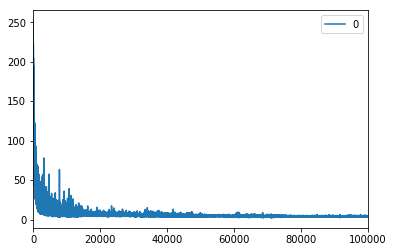

In [36]:
# 图示化训练过程中loss的变化
import pandas as pd
%matplotlib inline
pd.DataFrame(losses[:100000]).plot()

In [37]:
saver = tf.train.Saver()

In [38]:
saver.save(session,'models/word2vec_model')

'models/word2vec_model'

In [39]:
! ls -l 'models/word2vec_model.data-00000-of-00001'

-rw-r--r--  1 andrew  staff  16083216 Aug  1 11:50 models/word2vec_model.data-00000-of-00001


# 可视化

In [40]:
words_embedding = session.run(embeddings) #取出所有的embedding

In [42]:
from sklearn.decomposition import PCA

In [43]:
pca = PCA(n_components=2, svd_solver='full')

In [44]:
words_embedding_pca = pca.fit_transform(words_embedding) #映射到二维平面

In [52]:
# 可视化参数
import pypinyin
#zhfont1 = matplotlib.font_manager.FontProperties(fname='/usr/share/fonts/cjkunifonts-ukai/ukai.ttc')
from pylab import *
mpl.rcParams['font.sans-serif'] = ['Arial Unicode MS']
 
decisionNode = dict(boxstyle = "sawtooth", fc = "0.8")
leafNode = dict(boxstyle = "round4", fc = "0.8")
arrow_args = dict(arrowstyle = "<-")

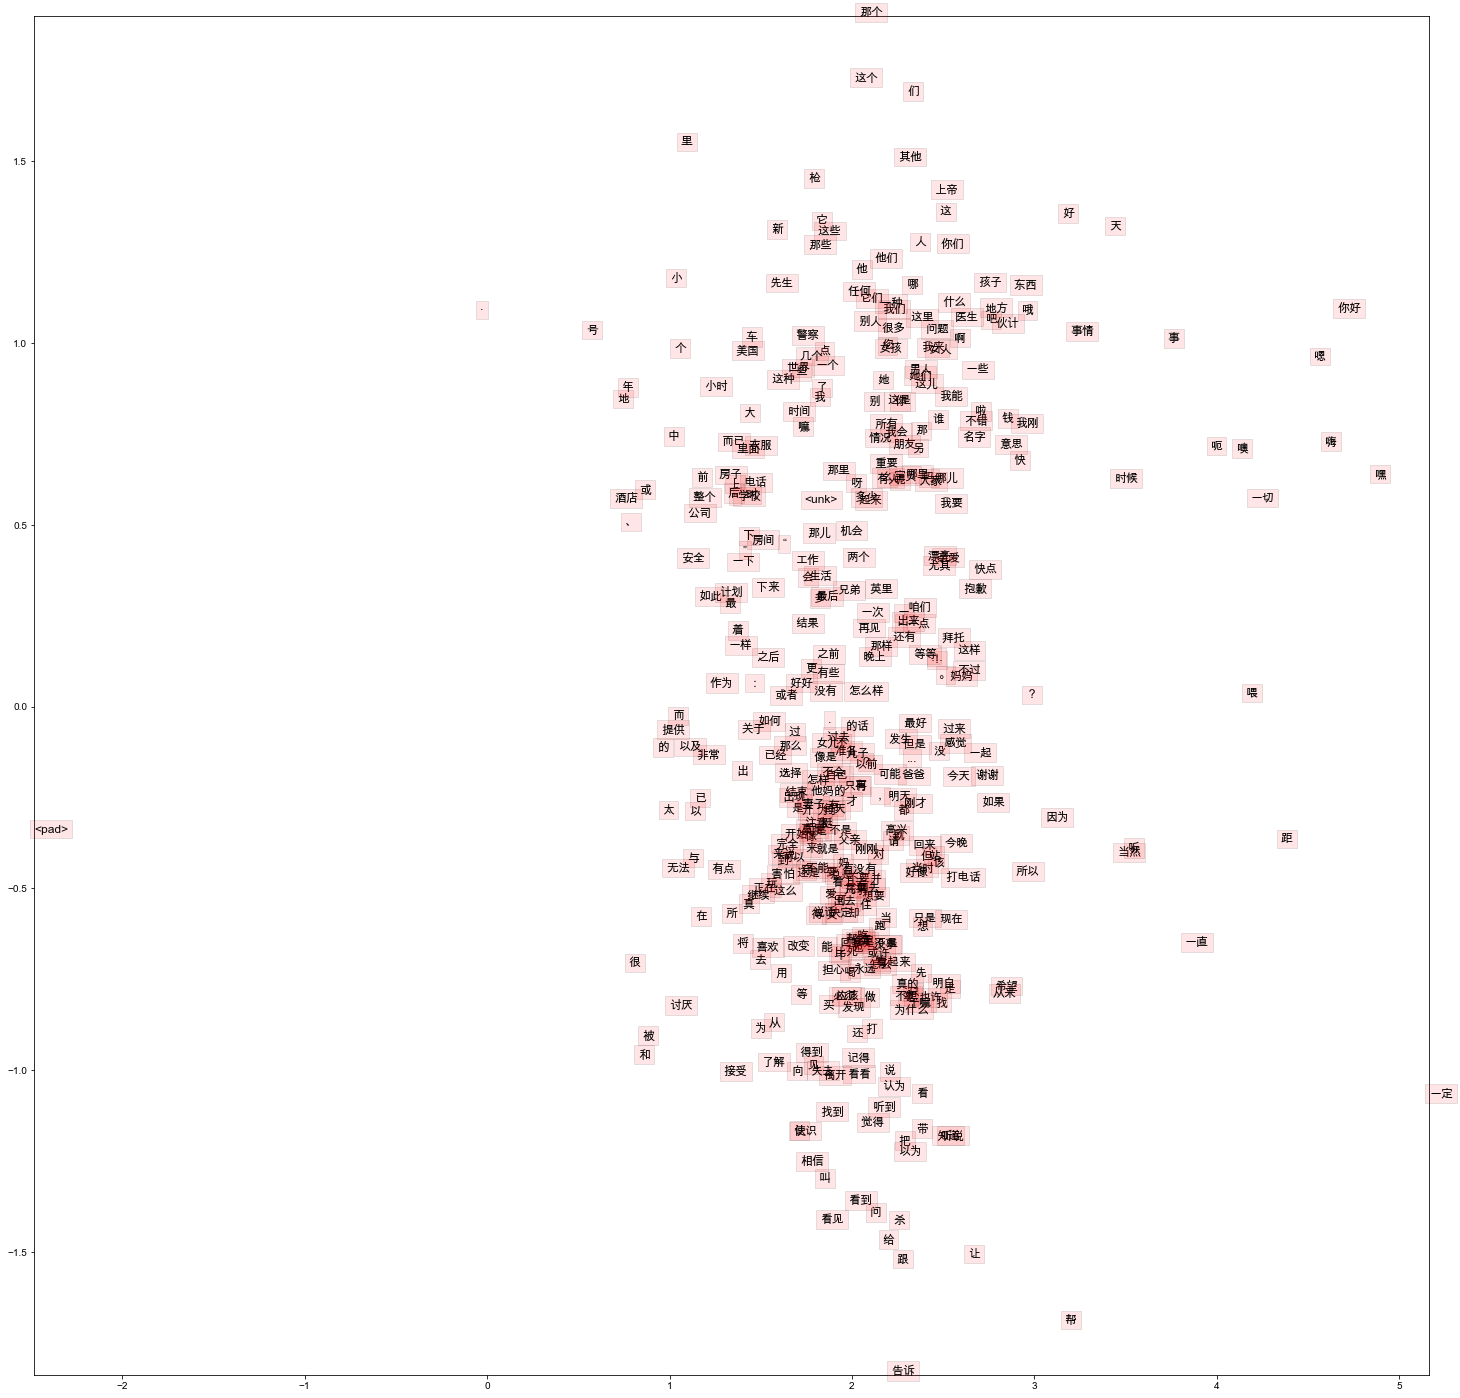

In [53]:
# 可视化400个汉字
plt.figure(figsize=(25,25))
for i in range(400):
    coord = words_embedding_pca
    color = 'red'
    plt.text(coord[i, 0], coord[i, 1],ind2ch[i], bbox=dict(facecolor=color, alpha=0.1),
             fontsize=12)  # fontproperties = ChineseFont1
plt.xlim((np.min(coord[:, 0]), np.max(coord[:, 0])))
plt.ylim((np.min(coord[:, 1]), np.max(coord[:, 1])))
plt.show()